# Introduction

In this notebook, the goal is to build a fully convolutional network for image denoising using the coulor version of LFWcrop.

In order, we will:
* Create a class to represent dataset of images faces
* Load datasets and visualize some of them
* Split dataset in train, test and validation set
* Definite the model
* Train the model
* Evaluate the model

In [1]:
# @title Installations and imports
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import random_split, DataLoader
from torchvision import models
import time
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

import torchvision.models as models

from torch.optim import SGD
!pip install torchmetrics
!pip install imageio[pyav]
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from PIL import Image
import os

import cv2
import imageio.v2 as imageio
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: ', device)

Device:  cuda:0


In [23]:
import requests
import zipfile

url = 'https://conradsanderson.id.au/lfwcrop/lfwcrop_color.zip'
response = requests.get(url)

if response.status_code == 200:
    with open('lfwcrop_color.zip', 'wb') as f:
        f.write(response.content)
    print('File downloaded successfully.')
else:
    print('Failed to download file.')

# Extract files to temporary location
with zipfile.ZipFile('lfwcrop_color.zip', 'r') as zip_file:
    zip_file.extractall()

File downloaded successfully.


Let's create the structure of the dataset and load it....

In [24]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, transform=None):
        self.data_paths = [root_path+f for f in sorted(os.listdir(root_path))]
        # self.label_paths = [f for f in sorted(os.listdir(root_path)) if f.startswith("label")]
        self.transform = transform

    def __getitem__(self, idx):
        img = imageio.imread(self.data_paths[idx])
        if self.transform:
            img = self.transform(img)
        return img#, label

    def __len__(self):
        return len(self.data_paths)

TRAIN_PATH = 'lfwcrop_color/faces/'
full_dataset = MyDataset(root_path=TRAIN_PATH, transform=transforms.ToTensor())

In [25]:
ratio = 0.1
shuffle_dataset = True
random_seed = 42

indices = list(range(len(full_dataset)))
split = int(np.floor(0.1 * len(full_dataset)))

np.random.seed(3333)
np.random.shuffle(indices)

train_size = int(ratio * len(full_dataset))
val_size = int(ratio * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

test_indices, val_indices,  train_indices = np.split(indices, [train_size, train_size + val_size])

train_sampler_true = SubsetRandomSampler(train_indices)
test_sampler_true = SubsetRandomSampler(test_indices)
valid_sampler_true = SubsetRandomSampler(val_indices)

test_sampler_true, valid_sampler_true,train_sampler_true = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

train_loader_true = torch.utils.data.DataLoader(train_sampler_true, batch_size=128, shuffle=True, num_workers=2)
valid_loader_true = torch.utils.data.DataLoader(valid_sampler_true, batch_size=128, shuffle=True, num_workers=2)
test_loader_true = torch.utils.data.DataLoader(test_sampler_true, batch_size=128, shuffle=False, num_workers=2)

Now, let us show some images

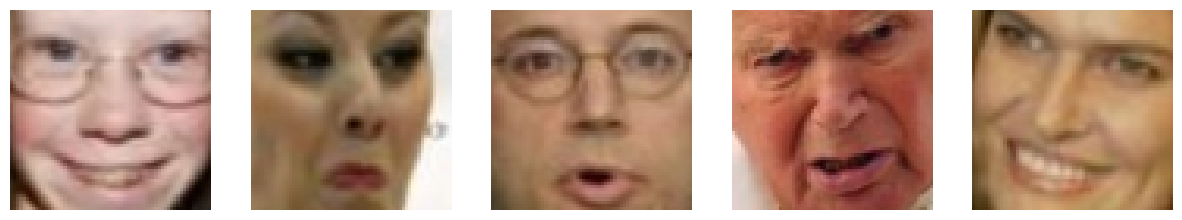

In [26]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))

for i in range(5):
  axs[i].imshow(train_sampler_true[i].permute(1,2,0).cpu().numpy())
  axs[i].axis('off')

For the model, the architecture is followin:
* encoder sequential:
 - two layers with the same number of neurons
 - kernel_size = 3
 - padding = 1
 - Relu function as activator
 - A MAx pooling with kernel size 2 and sride 2
* For decoding, we will use ConvTranspose2d in the deconvolution layer

In [27]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [30]:
model = DenoisingAutoencoder()
model.to(device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
         MaxPool2d-3           [-1, 64, 32, 32]               0
   ConvTranspose2d-4            [-1, 3, 64, 64]             771
              ReLU-5            [-1, 3, 64, 64]               0
Total params: 2,563
Trainable params: 2,563
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 4.69
Params size (MB): 0.01
Estimated Total Size (MB): 4.74
----------------------------------------------------------------


In [31]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

for epoch in range(num_epochs):
    total_loss = 0.0
    for data in tqdm(train_loader_true, desc=f"Epoch {epoch + 1}/{num_epochs}"):

        noisy_data = data + torch.randn_like(data)*0.1

        data, noisy_data = data.to(device), noisy_data.to(device)

        optimizer.zero_grad()

        outputs = model(noisy_data)
        outputs.to(device)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


Epoch 30/30: 100%|██████████| 83/83 [00:05<00:00, 15.26it/s]


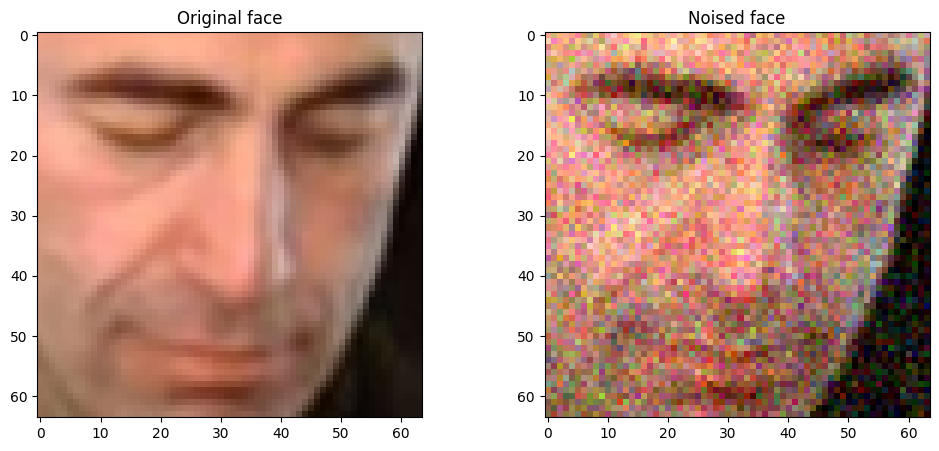

In [32]:
image = valid_sampler_true[6] + torch.randn_like(train_sampler_true[0])*0.1

noised = image.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(valid_sampler_true[6].permute(1,2,0).cpu().numpy())
plt.title('Original face')

plt.subplot(1, 2, 2)
plt.imshow(noised)
plt.title('Noised face')

plt.show()


Let us predict the face in this noisy image

<ipython-input-33-4b61555c9f83>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(image, dtype=torch.float)


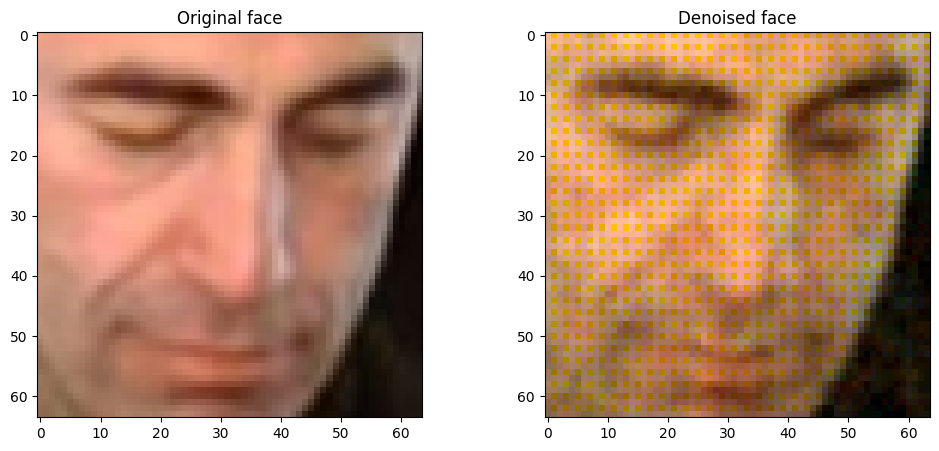

In [33]:
image = image.to(device)
input_data = torch.tensor(image, dtype=torch.float)
predicted = model(input_data)
denoised = predicted.permute(1, 2, 0).cpu().detach().numpy()  # Assuming channels are in the first dimension

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(valid_sampler_true[6].permute(1,2,0).cpu().numpy())
plt.title('Original face')

plt.subplot(1, 2, 2)
plt.imshow(denoised)
plt.title('Denoised face')

plt.show()

we can see an improvement in this image. The result could be very interesting for several iterations.

For evaluate the power of this model, we will use 3 metrics:
* Mean Square Error (MSE): More the MSE is low, best is the model
* Structure Similarity Index (SSI): it evaluates the structural similarity between the original image and the denoised image. It takes into account luminance, contrast and structure. An SSI value closer to 1 indicates better performance.
* Peak Signal-to-Noise Ratio (PSNR): A hight value of PSNR illustrates a good quality of this image

In [34]:
import torch
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

model.eval()

psnr_values = []
ssim_values = []
mse_values = []

for original_image in test_loader_true:
    noisy_image = original_image + torch.randn_like(original_image) * 0.1

    original_image, noisy_image = original_image.to(device), noisy_image.to(device)

    with torch.no_grad():
        denoised_image = model(noisy_image)

    psnr = peak_signal_noise_ratio(original_image.cpu().numpy(), denoised_image.cpu().numpy())
    ssim = structural_similarity(original_image.permute(0, 2, 3, 1).cpu().numpy(),
                                  denoised_image.permute(0, 2, 3, 1).cpu().numpy(), multichannel=True)
    mse = F.mse_loss(denoised_image, original_image).item()

    psnr_values.append(psnr)
    ssim_values.append(ssim)
    mse_values.append(mse)

average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_mse = np.mean(mse_values)

print(f"Average PSNR: {average_psnr:.2f} dB")
print(f"Average SSIM: {average_ssim:.4f}")
print(f"Average MSE: {average_mse:.4f}")

<ipython-input-34-43973557305d>:20: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(original_image.permute(0, 2, 3, 1).cpu().numpy(),


Average PSNR: 17.98 dB
Average SSIM: 0.8103
Average MSE: 0.0160


So, for the test set, we have the following metrics

<table>
  <tr>
    <td>
      METRIC
    </td>
    <td>
      VALUE
    </td>
  </tr>
  <tr>
    <td>
      Average PSNR
    </td>
    <td>
      17.98 dB
    </td>
  </tr>
  <tr>
    <td>
      Average SSIM
    </td>
    <td>
      0.8103
    </td>
  </tr>
  <tr>
    <td>
      Average MSE
    </td>
    <td>
      0.0160
    </td>
  </tr>
</table>



So, As the average of PNSR is 18dB, in mean, the quality of predicted image of test set is not that bad.

The indice of simillary is 81%, then in mean, the model produce an image simillar with the original image.

And finally, MSE is very small and acceptable